In [1]:
%matplotlib notebook

In [2]:
import rnutil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm

rnutil: Los archivos de los conjuntos de datos que ofrece este paquete también están disponibles en https://github.com/facundoq/redes-neuronales-util/tree/main/rnutil/data para descargar de forma individual
rnutil: Agregando el parámetro local=True en las funciones rnutil.load_dataset_numpy, rnutil.load_dataset_pandas y rnutil.load_image se puede cargar una versión local de un archivo en lugar de la versión que ofrece este paquete.


# Visualización del proceso de aprendizaje en Regresión Lineal 2D con descenso de gradiente

Funciones auxiliares (solo ejecutar, y seguir más abajo)

In [3]:
OptimizationState = namedtuple('OptimizationState', ['error_history','max_iterations'])
IterationState    = namedtuple('IterationState', ['iteration','mx','my','b','dEdmx','dEdmy', 'dEdb','zhat','errors','mean_error'])
OptimalModel      = namedtuple('Model', ['mx','my', 'b','error'])

PlotState = namedtuple('PlotState', ['figure','axes','legends'])

def optimal_model(x,y,z):
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    X=np.vstack([x,y]).T
    regr.fit(X,z)
    optimal_mx=regr.coef_[0]
    optimal_my=regr.coef_[1]
    optimal_b=regr.intercept_
    optimal_z=x*optimal_mx+y*optimal_my+optimal_b
    optimal_error=((optimal_z-z)**2).mean()
    return OptimalModel(optimal_mx,optimal_my,optimal_b,optimal_error)

def draw_plane(ax,mx,my,b,cmap):
    detail=0.05
    xr = np.arange(0, 40, detail)
    yr = np.arange(0, 10, detail)
    xx,yy = np.meshgrid(xr,yr)
    zz=xx*mx+yy*my+b
    surf = ax.plot_surface(xx,yy,zz, cmap=cmap,alpha=0.2,linewidth=0, antialiased=True)                   
    
def init_data(ax_data,x,y,z,optimal,mx,my,b):
    ax_data.scatter(x,y,z,color="blue")
    draw_plane(ax_data,optimal.mx,optimal.my,optimal.b,'Greens')
    draw_plane(ax_data,mx,my,b,'Reds')
    ax_data.set_xlabel("x1 (Horas estudiadas)")
    ax_data.set_ylabel("x2 (Promedio)")
    ax_data.set_zlabel("y (Nota)")
    ax_data.set_title("(Horas estudiadas x Promedio) vs Nota")
    
    
def init_error_history(ax_error):
    ax_error.set_xlabel("Iteración")
    ax_error.set_ylabel("Error")
    ax_error.set_title("Historial de Error")
    
def init_plot(x,y,z,optimal,mx,my,b):
    
    figure=plt.figure(figsize=(13,5), dpi=100)
    
    ax_data=figure.add_subplot(1,2,1,projection='3d')
    ax_error=figure.add_subplot(1,2,2)
    axes=(ax_data,ax_error)
    
    init_data(ax_data,x,y,z,optimal,mx,my,b)
    init_error_history(ax_error)
    
    return PlotState(figure,axes,None)

def visualizar(plot_state,x,y,z,iteration_state,optimal,optimization_state):
    (ax_data,ax_error)=plot_state.axes
    # Visualizacion
    
    #actualizar plano del modelo actual
#     print(dir(ax_data))
    ax_data.collections.pop()
    
    draw_plane(ax_data,iteration_state.mx,iteration_state.my,iteration_state.b,'Reds')
    
    # Mostrar leyendas
    model = patches.Patch(color='red', label='Modelo: y=x1*({:.2f})+x2*({:.2f})+({:.2f})'.format(iteration_state.mx,iteration_state.my,iteration_state.b))
    model_true = patches.Patch(color='green', label='Modelo óptimo: y=x1*({:.2f})+x2*({:.2f})+({:.2f})'.format(optimal.mx,optimal.my,optimal.b))
    label='$\\frac{ \\partial E}{\\partial m_1}=$ %.2f, $\\frac{ \\partial E}{\\partial m_2}=$ %.2f,, $\\frac{ \\partial E}{\\partial b}$ %.2f' %(iteration_state.dEdmx,iteration_state.dEdmy,iteration_state.dEdb)
    derivatives = patches.Patch(color='red', label=label)
    error_patch = patches.Patch(color='red', label='$E=\\frac{1}{n} \sum_i^n E_i=$ %.2f' % (iteration_state.mean_error))
    optimal_error = patches.Patch(color='green', label='E del modelo óptimo: %.2f' % (optimal.error))
    handles=[model,derivatives,error_patch,model_true,optimal_error]
    
    
    ax_error.lines.clear()
    ax_error.plot(optimization_state.error_history,color="blue")
    ax_error.set_xlim(0,optimization_state.max_iterations)
    ymin,ymax=ax_error.get_ylim()
    ax_error.set_ylim(0,ymax)
    ax_error.legend(handles=handles)
    plt.suptitle("Entrenamiento de modelo lineal, Iteración %03d / %03d" % (iteration_state.iteration+1,optimization_state.max_iterations))
    
    plot_state.figure.canvas.draw()

# Visualización del modelo y la curva de error durante el aprendizaje

El siguiente código entrena un modelo de regresión lineal $f(x)=m_1 x_1+ m_2 x_2+b$ con descenso de gradiente.

Para eso se muestran 2 gráficos durante la optimización:
* Los datos y el modelo, con los valores del error medio y las derivadas de los parámetros.
* La curva de error, que indica el error del modelo para cada iteración del algoritmo

Estos gráficos se actualizan en cada iteración del algoritmo, de modo de poder ver el recorrido de los valores $m_1$, $m_2$ y $b$, como eso afecta al modelo, y como va minimizándose el error en consecuencia.

Probá modificando:
* Los valores iniciales de los parámetros $m_1$, $m_2$ y $b$
* La tasa de aprendizaje $α$
* La cantidad de iteraciones máximas `max_iterations`

Y comprendiendo como estos valores inciden en el algoritmo. Respondé:

* ¿Qué valores de $α$ permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?
   * **RE**: $α=0.001$ converge albalor mas bajo posible 0.72. Con valores mas bajos de $α$ no se logra un error menor a 0.76 y ademas esto aumenta el tiempo de ajuste y por ende la cantidad de iteraciones necesarioas para llegar a erroes cercanos.
* ¿Se alcanza siempre el mínimo global (plano verde)?
  * **RE**: No lo eh alcanzado un error menor a 0.72.
* ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?
  * **RE**: el numero de iteraciones y $α$ son oos parametros que mas inciden. Los calores iniciales de los pesos tambien ayudan a que el modelo converja mas rapidamente.
* ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?
  * **RE**: No las veribadas cambian enc ada itieracion debido a que el valor de los pesos se modifica en cada iteracion.
* ¿Cuál es el máximo valor de $α$ antes de que el algoritmo comience a diverger?
    * **RE**: $α=0.0015$ aprox. 

Luego de eso, normalizá los datos de entrada $x$ restándoles la media $μ$ y dividiendo por la desviación estándar $σ$ con la fórmula $x ← (x-μ)/σ$. Recordá que $x$ es un vector de NumPy y por ende soporta los métodos `mean()` y `std()`. 

Volvé a responder las preguntas anteriores ahora con los datos normalizados.

**RE**

En este caso el modelo converge a muy alta velocidad. Es decir, se puede utilizar un $α$ muy grande de 0.1 sin que el modelo diverja y aun asi el modelo llega al minimo global en un número de itraciones muy bajo (25). En resumen normalizar ayudo a la optimización del gradiente descendente a converger al minimo global y ademas aumentando la velocidad de ajuste en gran medida. 

Otro punto importante: los valores initiales de los parametro ya no estan afectando a la optimizacion, Es decir, valores iniciales alejados de los reales no afecta al tiempo de ajuste, y tampoco al ajuste en si el cual tambien llega al minimo global con facilidad.

Todo esto se logra debido a que al normalizar las varaibles la superficie del error se vuelve convexa y por lo tanto solo hay un minimo global en la funcion de error al cual se puede llegar siempre ajustando al $α$ y número de iteraciones correcto.

## Carga de datos

In [4]:
data = rnutil.load_dataset_numpy("study_regression_2d_small.csv")

x1, x2, y = data[:, 0], data[:, 1], data[:, 2]

Loading file from package rnutil (/home/adrian/.conda/envs/rn/lib/python3.10/site-packages/rnutil/data)...
Done


## Normalización

In [5]:
x1 = (x1 - x1.mean()) / x1.std()
x2 = (x2 - x2.mean()) / x2.std()

## Parámetros iniciales del modelo (probar valores entre -5 y 5)

In [12]:
m1 = 5
m2 = 5
b  = 0

## Configuración del descenso de gradiente

In [13]:
#iteraciones máximas a realizar
max_iterations = 25

#velocidad de aprendizaje
#valores sensatos: entre 0.00001 y 0.001 (pero probá otros también!)
alpha = 0.1

## Cálculo del valor óptimo mediante cuadrados mínimos

In [14]:
optimal=optimal_model(x1,x2,y)

## Inicialización del algoritmo

In [15]:
iteration     = 0
mean_error    = 0
error_history = []

## Opciones de visualización 

In [16]:
# indica cuanto tiempo se espera  entre una actualización de los gráficos y la otra
# el tiempo a esperar es (1/fps), por ende valores más altos de fps aumentan la velocidad 
# de la animación
fps = 20

<IPython.core.display.Javascript object>


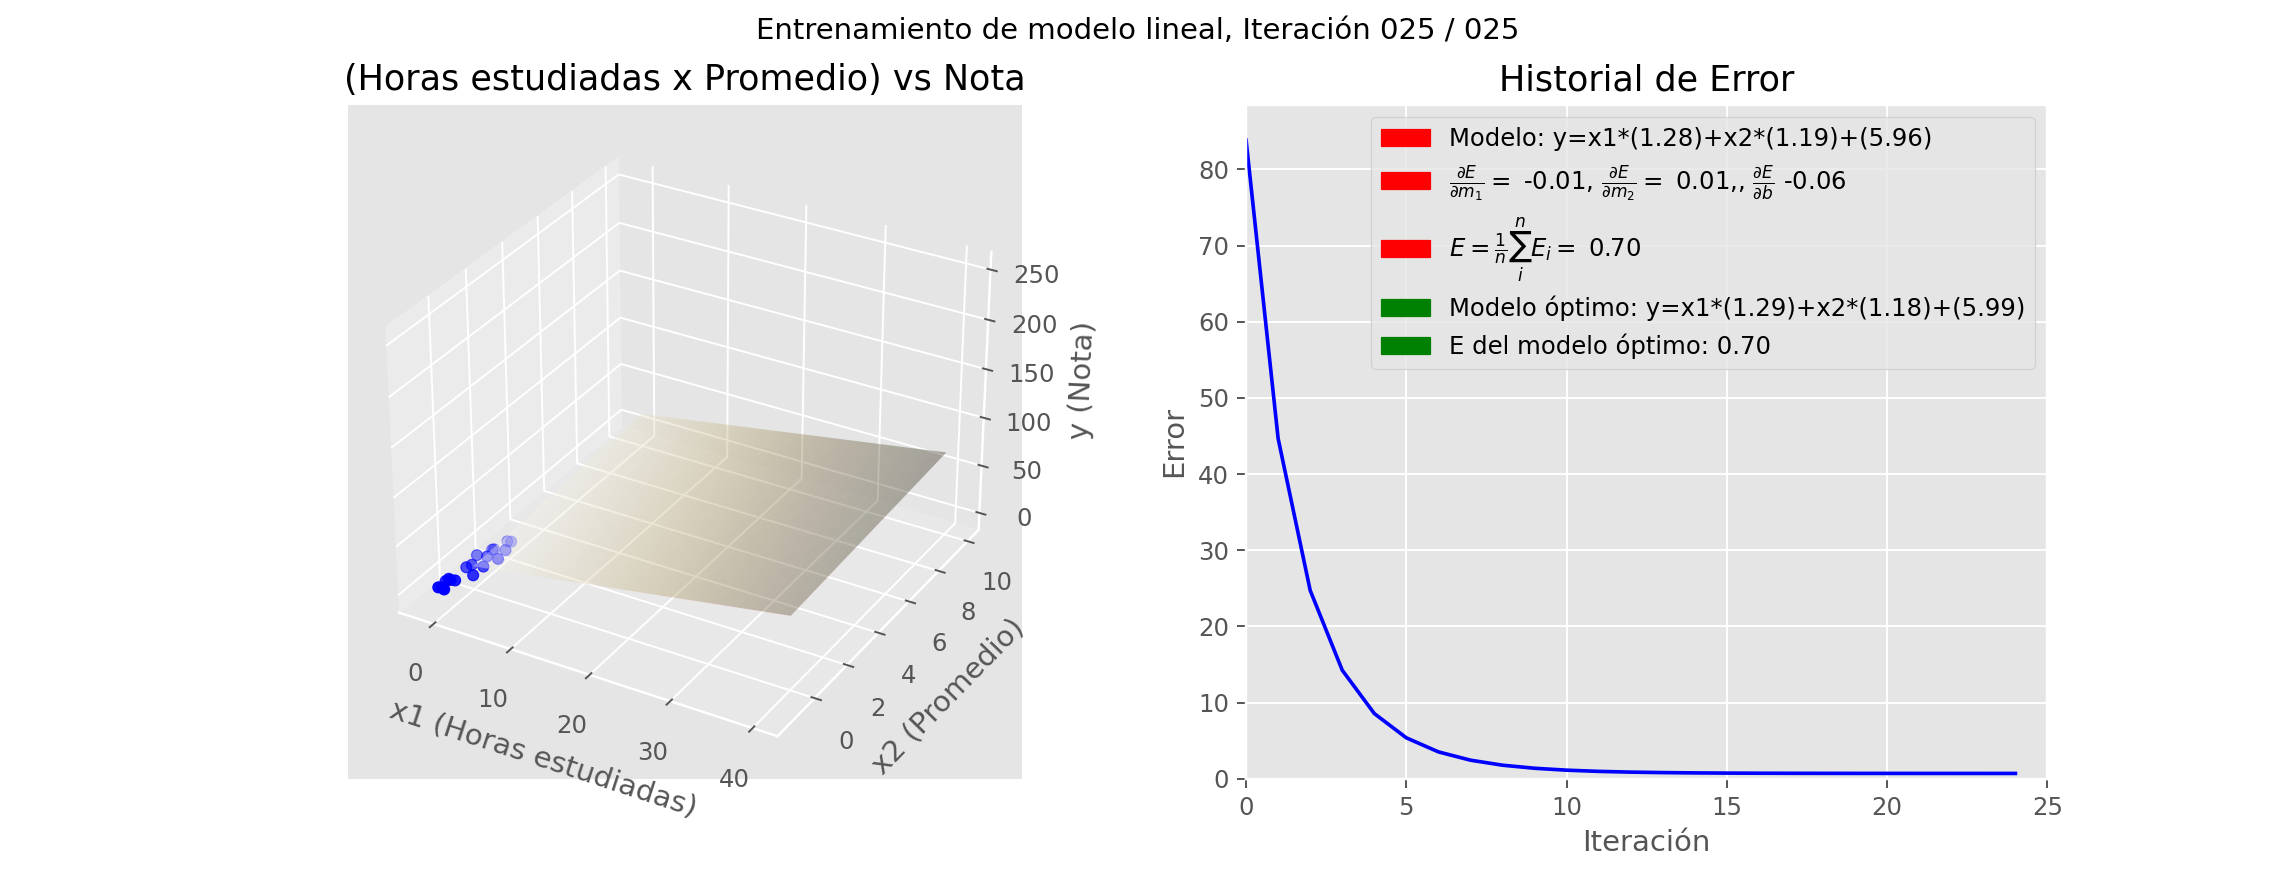

In [17]:
plot_state         = init_plot(x1,x2,y,optimal,m1,m2,b)
optimization_state = OptimizationState(max_iterations=max_iterations,error_history=[])

while iteration<optimization_state.max_iterations:
    #predicciones del modelo
    y_pred=x1*m1 + x2*m2+b
    #calculo de derivadas
    delta = y_pred-y
    dEdm1=2*(delta*x1).mean()
    dEdm2=2*(delta*x2).mean()
    dEdb=2*(delta).mean()
    
    #CALCULO DE ERROR
    #Calculo del error del modelo
    errors= (delta)**2
    mean_error=errors.mean()
    optimization_state.error_history.append(mean_error)
    #FIN CALCULO DE ERROR
    
    #visualización
    # indica cada cuantas iteraciones del 
    # descenso de gradiente se actualizan los gráficos
    # valores muy chicos ralentizan el dibujo
    plot_every_n_iterations = 3
    if (iteration % plot_every_n_iterations ==0):
        iteration_state=IterationState(iteration,m1,m2,b,dEdm1,dEdm2, dEdb,y_pred,errors,mean_error)
        visualizar(plot_state,x1,x2,y,iteration_state,optimal,optimization_state)
        plt.pause(1/fps)
    # fin visualización
    
    #DESCENSO DE GRADIENTE
    #actualizo los parámetros
    m1=m1-alpha*dEdm1
    m2=m2-alpha*dEdm2
    b=b-alpha*dEdb
    # FIN DESCENSO DE GRADIENTE
    
    iteration+=1